# Using the Shadowverse Card API and creating hashes

## Introduction
Using the Shadowverse Card API, we can query the information on cards present in Shadowverse. Several details are available for each cards; the focus would be to extract details of legal cards and relevant information. These information can be used for subsequent projects. The `pandas` library will be used for majority of this notebook.

## Sources:
- [API Documentation](https://gist.github.com/theabhishek2511/dfd54989013254324cc4d67f1dbc9f7f)
- [ID, Hash, shadowverse-portal URL Construction](https://tdtomatomato.hatenablog.com/entry/2019/01/28/235642)

## Main Objective: card_id & hash

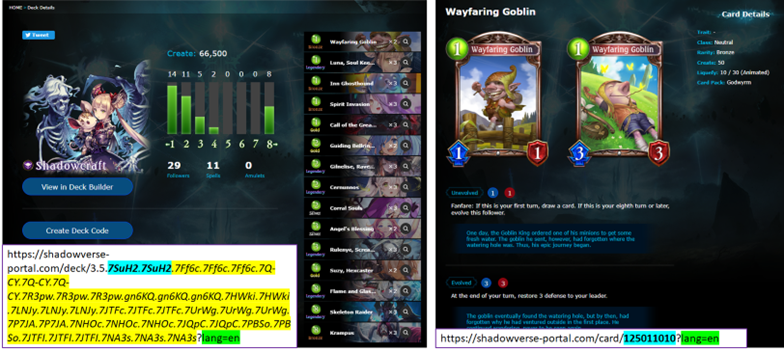

There are some pages that are commonly seen and used on the Shadowverse-portal site:
- [shadowverse-portal.com/deck](https://shadowverse-portal.com/deck/3.2.7SuH2.7SuH2.7PtPS.7PtPS.7PtPS.7ThYI.7ThYI.7IDPw.7IDPw.7HWki.7HWki.7S_by.7S_by.7S_by.7PyHo.7PyHo.7PyHo.7Tj-i.7Tj-i.7Tj-i.7S_c6.7S_c6.7S_c6.7EVt6.7EVt6.7EVt6.7M88o.7M88y.7IKkg.7IKkg.7IKkg.7M8tg.7M8tg.7M8tg.7ETQY.7ETQY.7ETQY.7IJ_o.7IJ_o.7IJ_o?lang=en)
- [shadowverse-portal.com/card](https://shadowverse-portal.com/card/125011010?lang=en)
- [shadowverse-portal.com/deckbuilder/create](https://shadowverse-portal.com/deckbuilder/create/2?hash=3.2.7SuH2.7SuH2.7PtPS.7PtPS.7PtPS.7ThYI.7ThYI.7IDPw.7IDPw.7HWki.7HWki.7S_by.7S_by.7S_by.7PyHo.7PyHo.7PyHo.7Tj-i.7Tj-i.7Tj-i.7S_c6.7S_c6.7S_c6.7EVt6.7EVt6.7EVt6.7M88o.7M88y.7IKkg.7IKkg.7IKkg.7M8tg.7M8tg.7M8tg.7ETQY.7ETQY.7ETQY.7IJ_o.7IJ_o.7IJ_o&lang=en) **[Strongly Discouraged]**

As shown above, hashes and card_id appears in different pages. However, the API only provides card_id. In order to derive the hash, we use a base64 encoding that is special to Shadowverse (not the conventional one). Luckily for us, the steps has been documented by tdTomato. This will be further elaborated below.

In [3]:
# importing all the libraries
import requests
import math
import os
import pandas as pd

In [4]:
## Store API URL. 
target_url = f'https://shadowverse-portal.com/api/v1/cards'
## Make a GET request to access API URL. Returns a JSON. Then convert the JSON into a DataFrame. Then generate a DataFrame.
result = requests.get(target_url, params = {"format": "json", "lang": "en"})
src = result.json()
df = pd.DataFrame(src['data']['cards'])

## Creating a DataFrame from the API

After calling the API, we have a DataFrame of all available cards which also includes Tokens.
Using `df.columns`, we see several columns that are not of our interest. Some of these fields are only available in `"lang": "jp"`, which ended up as null values in other languages.

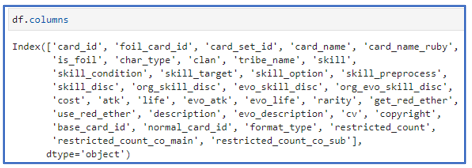


Furthermore, upon some exploration there are some rows where card_name ends with trailing white spaces. 

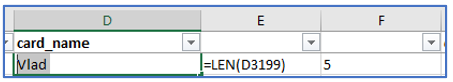

Note that alternate/tie-in cards have different card_set_id and card_id that differs from their base_card_id. For such cases, we would also need to create new columns to point such cards to the original card, in this case called base_card_name.

## The tasks
After some data exploration of our query from the API, I have an idea of what goals I want to achieve:
> - Take only useful information (exclude columns, exclude rows where cards are Tokens)
> - Clean the data, derive the hash.
> - Create a base_card_name column for alternate/tie-in cards.

In [3]:
## Clean the data and extract what we need.
## Remove rows without card_name
df2 = df.loc[df['card_name'].notna() == True].reset_index(drop = True).copy()
## Remove rows where cards are tokens (starting with 90). card_set_id starting with 10 are released sets; 70 are collabs/tie-in/alternates.
df2 = df2.loc[df2['card_set_id'] < 90000].reset_index(drop = True).copy()
df2 = df2[['card_set_id', 'clan', 'rarity', 'char_type', 'cost', 'card_name', 'card_id', 'base_card_id']]

## Clean trailing white spaces in some card_name
df2["card_name"] = df2["card_name"].apply(lambda x: x.rstrip())

## Create a dictionary of base cards with their ids (cards with alternate arts)
df3 = df2.loc[df2["card_id"] == df2["base_card_id"]].copy()
df3 = df3[["base_card_id", "card_name"]].set_index("base_card_id")
basecardsdict = df3.to_dict()['card_name']

## Create column base_card_name to standardise cards with alternate arts 
df2['base_card_name'] = df2['base_card_id']
df2['base_card_name'] = df2['base_card_name'].apply(lambda x: str(x).replace(str(x), basecardsdict[x]))

## Nested sort
df2 = df2.sort_values(by = ['card_set_id', 'clan', 'card_id'], ascending = [False, True, True]).reset_index(drop = True)

In [4]:
## Base64 notation dictionary for Shadowverse
base64 = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J',
 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T',
 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'c', 39: 'd',
 40: 'e', 41: 'f', 42: 'g', 43: 'h', 44: 'i', 45: 'j', 46: 'k', 47: 'l', 48: 'm', 49: 'n',
 50: 'o', 51: 'p', 52: 'q', 53: 'r', 54: 's', 55: 't', 56: 'u', 57: 'v', 58: 'w', 59: 'x',
 60: 'y', 61: 'z', 62: '-', 63: '_'}
## Dictionaries for replace
classdict = {0: "Neutral", 1: "Forestcraft", 2: "Swordcraft", 3: "Runecraft", 4: "Dragoncraft", 5: "Shadowcraft", 6: "Bloodcraft", 7: "Havencraft", 8: "Portalcraft"}
raritydict = {1: "Bronze", 2: "Silver", 3: "Gold", 4: "Legendary"}
cardtypedict = {1: "Follower", 2: "Amulet", 3: "Countdown Amulet", 4: "Spell"}

## Calculating hash and replacing values

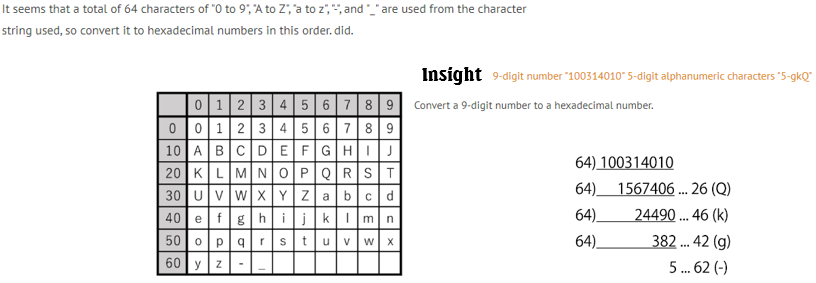

In creating the hash for each corresponding card_id, we perform a series of calculation from base10 to base64. 
From my understanding of [tdtomato's](https://tdtomatomato.hatenablog.com/entry/2019/01/28/235642) explanation, we repeatedly divide the card_id by 64 rounded down, in which we use the function `math.floor()` from the `math` library.

> **For each division step:**
> - The quotient gets divided again.
> - The remainder (or modulo) becomes the hash character, starting from the last to the first digit.
>    - As such, I reversed the order of the list before replacing the remainder with the corresponding hash character.

Using `apply-lambda`, I was able to use a function and run it through all the cards to generate the hashes.
You could also consider using list comprehension if that's your thing.

Similarly, we use dictionaries to replace the classes, rarity and card type from int to str values.

In [5]:
## Create hash from card_id
def IdToHash(card_id):
    list1 = []
    for n in range(0, 6):
        divide = card_id*((1/64)**n)
        mod = math.floor(divide%64)
        list1.append(math.floor(mod))
        
    list2 = list(reversed(list1[:-1]))
    output = ""
    for m in list2:
        hashvalue = str(m).replace(str(m), base64[m])
        output += (hashvalue)
        
    return output

df2["hash"] = df2["card_id"].apply(lambda x: IdToHash(x))

In [6]:
## Create hash from card_id
# df2["hash"] = df2.apply(lambda x: [math.floor(y%64) for y in [math.floor(x["card_id"]*((1/64)**n)) for n in range(0, 6)]][:-1], axis = 1)
# df2["hash"] = df2["hash"].apply(lambda x: [str(each).replace(str(each), base64[each]) for each in list(reversed(x))])
# df2["hash"] = df2["hash"].apply(lambda x: "".join(x))

In [7]:
## Replace values
df2["clan"] = df2["clan"].apply(lambda x: str(x).replace(str(x), classdict[x]))
df2["rarity"] = df2["rarity"].apply(lambda x: str(x).replace(str(x), raritydict[x]))
df2["char_type"] = df2["char_type"].apply(lambda x: str(x).replace(str(x), cardtypedict[x]))

## Save the output DataFrame

In [8]:
## Save to .xlsx file
writer = pd.ExcelWriter(f"SVCardInfo.xlsx")
df2.to_excel(writer, sheet_name="FileData", index=False)
writer.save()